In [1]:
! pip install -q kaggle

In [2]:
# Import Libraries
import os
from torchvision.models import resnet18, vgg16, efficientnet_b0
import torch.nn as nn
import torch.optim as optim
from google.colab import files
import numpy as np
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [3]:
# Upload Kaggle API key
files.upload()  # This will prompt you to upload your 'kaggle.json' file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"suhpan","key":"77f2ff7ead93e044c7fb4f18c7ac72fe"}'}

In [4]:
# Set up Kaggle credentials
os.environ['KAGGLE_CONFIG_DIR'] = "/content"  # Set the path to where kaggle.json is stored

# Download the dataset from Kaggle
!kaggle datasets download -d chrisfilo/fruit-recognition  # This is the dataset URL path

# Extract the dataset (if it's in a zip format)
!unzip fruit-recognition.zip -d /content/fruit-recognition  # Unzip the dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00322.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00323.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00324.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00325.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00326.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00327.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00328.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00329.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet0033.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00330.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00331.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet00332.png  
  inflating: /content/fruit-recognition/Pomegranate/Pomegranet

In [5]:
def reduce_dataset(dataset, num_per_class):
    class_counts = {cls: 0 for cls in range(len(dataset.classes))}
    indices = []

    for idx, (_, label) in enumerate(dataset):
        if class_counts[label] < num_per_class:
            indices.append(idx)
            class_counts[label] += 1
        if all(count >= num_per_class for count in class_counts.values()):
            break

    return Subset(dataset, indices)

# Dataset path
data_dir = "fruit-recognition"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [6]:
# Reduce dataset to 200 images per class
num_per_class = 200
reduced_dataset = reduce_dataset(dataset, num_per_class)

# Split reduced dataset into train/val
train_size = int(0.8 * len(reduced_dataset))
val_size = len(reduced_dataset) - train_size
train_dataset, val_dataset = random_split(reduced_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Updated dataloaders dictionary
dataloaders = {
    "train": train_loader,
    "val": val_loader
}

print(f"Reduced dataset size: {len(reduced_dataset)}")
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Reduced dataset size: 3000
Training samples: 2400, Validation samples: 600


In [7]:
# Class names
classes = dataset.classes
print(f"Classes: {classes}")

Classes: ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # image size is 224x224, after pooling it will be 28x28
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # Define forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
import time
import copy
import torch

# Trains a PyTorch model, tracking loss and accuracy for training and validation
def train_model_with_accuracy(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store history for visualization
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Track loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save metrics
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # Load best model weights
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")

    return history


In [10]:
results = {}
models_dict = {
    "CNN": SimpleCNN(num_classes=len(dataset.classes)), # "SimpleCNN
    "ResNet18": resnet18(pretrained=True),
    # "VGG16": vgg16(pretrained=True),
    "EfficientNet": efficientnet_b0(pretrained=True),
}

# Train and save models
for model_name, model in models_dict.items():
    if model_name == "CNN":
        model = SimpleCNN(num_classes=len(dataset.classes))
    elif model_name == "ResNet18":
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, len(dataset.classes))
    elif model_name == "VGG16":
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, len(dataset.classes))
    elif model_name == "EfficientNet":
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(dataset.classes))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    history = train_model_with_accuracy(model, dataloaders, criterion, optimizer, num_epochs=10)
    results[model_name] = history

    # Save the model
    torch.save(model.state_dict(), f"{model_name}_fruit_recognition_model.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Epoch 1/10
----------
train Loss: 1.9384 Acc: 0.3983
val Loss: 1.0519 Acc: 0.6733
Epoch 2/10
----------
train Loss: 0.6206 Acc: 0.8163
val Loss: 0.4255 Acc: 0.8900
Epoch 3/10
----------
train Loss: 0.2982 Acc: 0.9100
val Loss: 0.2769 Acc: 0.9083
Epoch 4/10
----------
train Loss: 0.2370 Acc: 0.9296
val Loss: 0.3141 Acc: 0.9100
Epoch 5/10
----------
train Loss: 0.1883 Acc: 0.9383
val Loss: 0.2184 Acc: 0.9300
Epoch 6/10
----------
train Loss: 0.1363 Acc: 0.9542
val Loss: 0.2624 Acc: 0.9317
Epoch 7/10
----------
train Loss: 0.0976 Acc: 0.9713
val Loss: 0.1677 Acc: 0.9617
Epoch 8/10
----------
train Loss: 0.0754 Acc: 0.9775
val Loss: 0.2817 Acc: 0.9283
Epoch 9/10
----------
train Loss: 0.0749 Acc: 0.9767
val Loss: 0.2370 Acc: 0.9300
Epoch 10/10
----------
train Loss: 0.0911 Acc: 0.9696
val Loss: 0.1604 Acc: 0.9600
Training complete in 4m 30s
Best validation accuracy: 0.9617
Epoch 1/10
----------
train Loss: 0.3711 Acc: 0.8896
val Loss: 0.4602 Acc: 0.9117
Epoch 2/10
----------
train Loss: 0.

In [11]:
def evaluate_models(model, dataloader):
    """Evaluate the model on the validation dataset."""
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    accuracy = running_corrects.double() / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")
    return accuracy


In [12]:
# Evaluate and visualize results
for model_name, model in models_dict.items():
    print(f"\nEvaluating {model_name}...\n")
    model.load_state_dict(torch.load(f"{model_name}_fruit_recognition_model.pth"))
    model = model.to(device)
    evaluate_models(model, dataloaders["val"])


Evaluating CNN...



<ipython-input-12-dce18c26a917>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}_fruit_recognition_model.pth"))


Validation Accuracy: 0.9500

Evaluating ResNet18...

Validation Accuracy: 0.9833

Evaluating EfficientNet...

Validation Accuracy: 1.0000


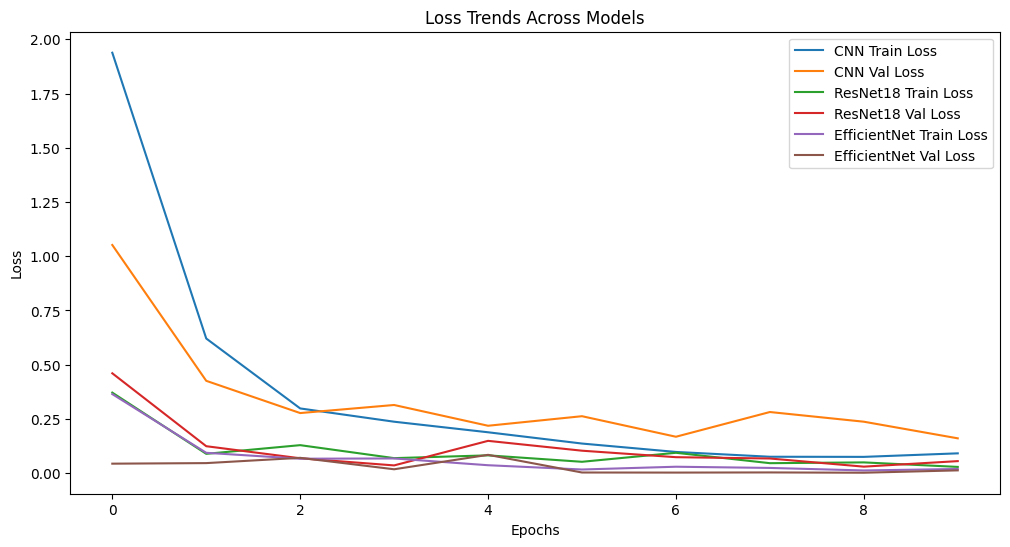

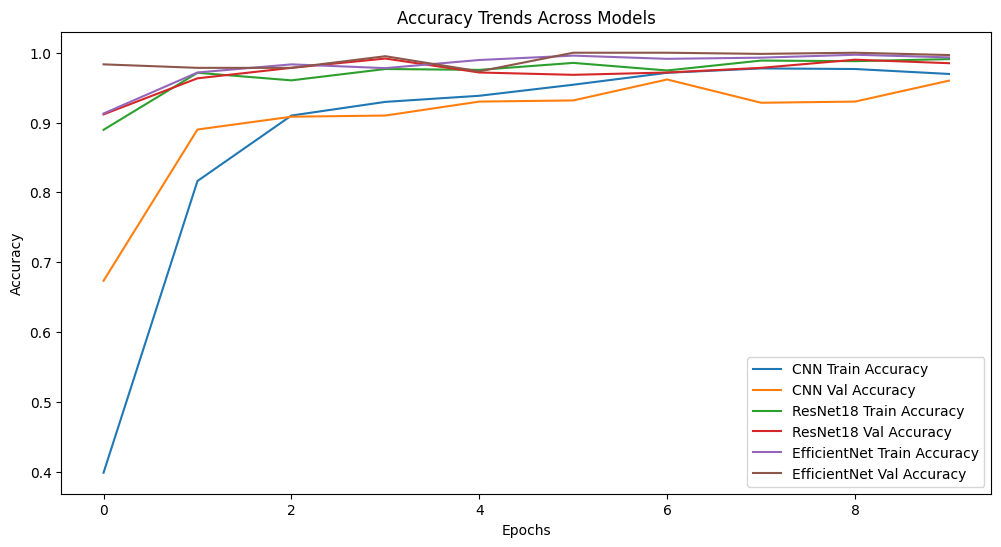

In [13]:
def plot_loss_and_accuracy(results):
    # Plot Loss
    plt.figure(figsize=(12, 6))
    for model_name, history in results.items():
        plt.plot(history["train_loss"], label=f"{model_name} Train Loss")
        plt.plot(history["val_loss"], label=f"{model_name} Val Loss")
    plt.title("Loss Trends Across Models")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    for model_name, history in results.items():
        plt.plot(history["train_acc"], label=f"{model_name} Train Accuracy")
        plt.plot(history["val_acc"], label=f"{model_name} Val Accuracy")
    plt.title("Accuracy Trends Across Models")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Visualize Loss and Accuracy
plot_loss_and_accuracy(results)

Confusion Matrix for CNN


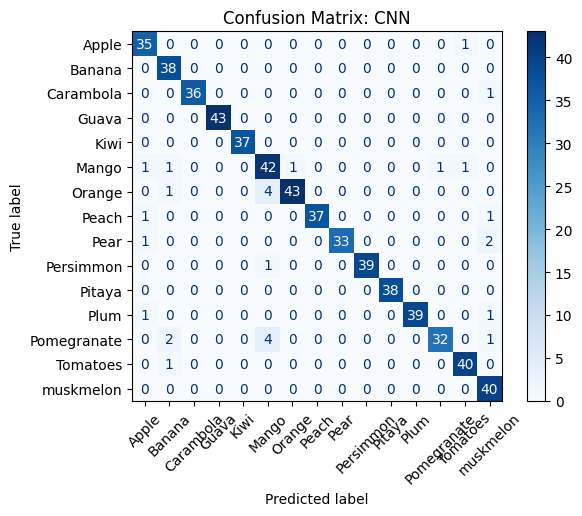

Confusion Matrix for ResNet18


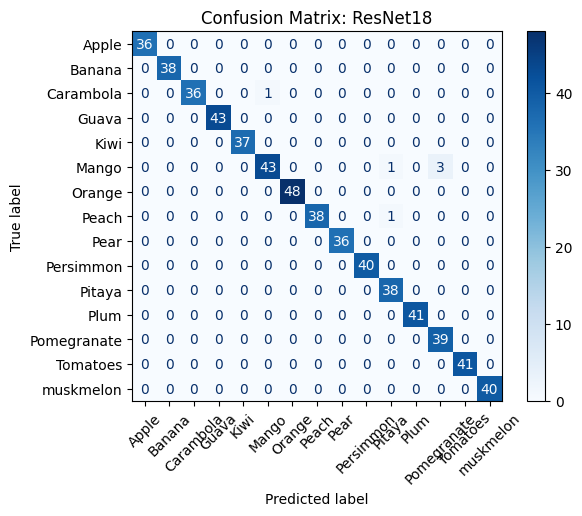

Confusion Matrix for EfficientNet


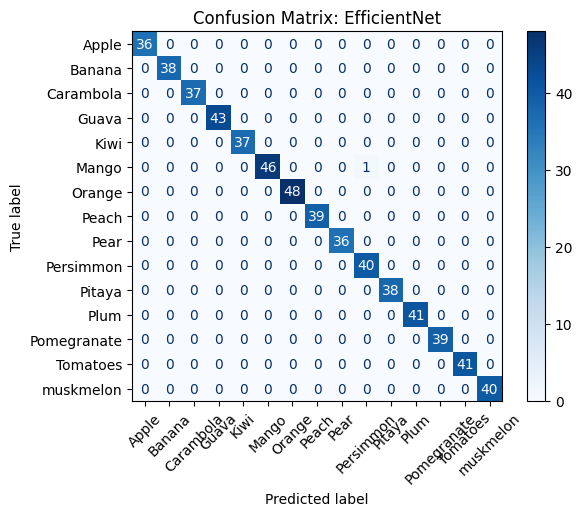

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix_for_models(models_dict, dataloader, classes):
    for model_name, model in models_dict.items():
        print(f"Confusion Matrix for {model_name}")
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Confusion Matrix: {model_name}")
        plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix_for_models(models_dict, dataloaders["val"], classes)


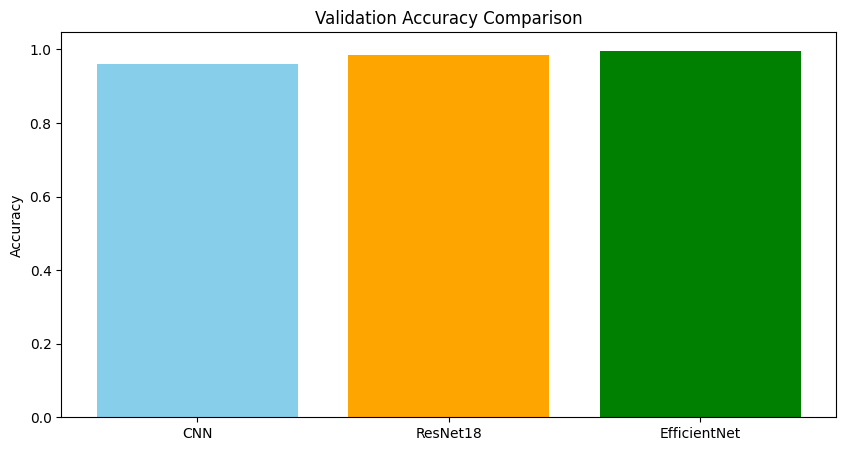

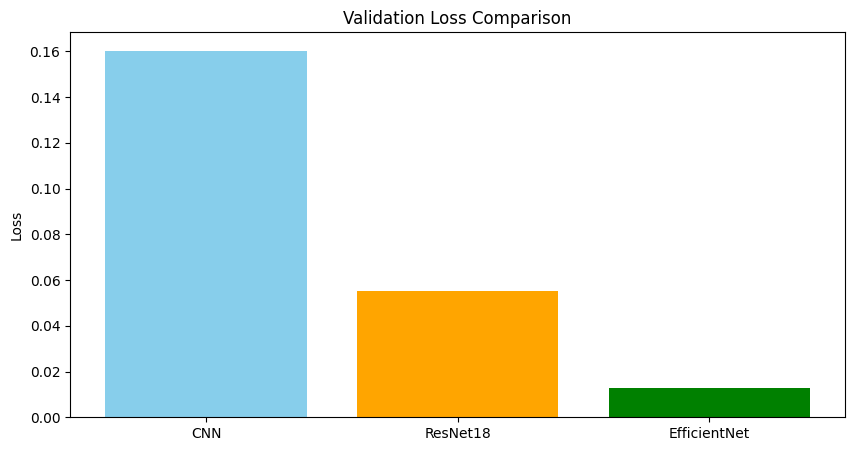

In [15]:
import numpy as np

def summarize_model_performance(results):
    model_names = []
    val_accs = []
    val_losses = []

    for model_name, history in results.items():
        model_names.append(model_name)
        val_accs.append(history["val_acc"][-1])  # Final validation accuracy
        val_losses.append(history["val_loss"][-1])  # Final validation loss

    # Bar chart for accuracy
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, val_accs, color=["skyblue", "orange", "green"])
    plt.title("Validation Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.show()

    # Bar chart for loss
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, val_losses, color=["skyblue", "orange", "green"])
    plt.title("Validation Loss Comparison")
    plt.ylabel("Loss")
    plt.show()

# Summarize performance
summarize_model_performance(results)
